In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns


pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import os


In [4]:
import sklearn
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import  SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
def reduce_mem_usage(df, verbose=True):  #reduce memory usage
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
#Load train data
train_data = reduce_mem_usage(pd.read_csv(r'D:\Permagangan duniawi\MBKM\Data Analyst\Final Project\application_train.csv\application_train.csv'))

#Load test data
test_data = reduce_mem_usage(pd.read_csv(r'D:\Permagangan duniawi\MBKM\Data Analyst\Final Project\application_test.csv\application_test.csv'))

#Load bureau data
bureau_data=reduce_mem_usage(pd.read_csv(r'D:\Permagangan duniawi\MBKM\Data Analyst\Final Project\Final Project\bureau.csv'))

#Load previous app
previous_app=reduce_mem_usage(pd.read_csv(r'D:\Permagangan duniawi\MBKM\Data Analyst\Final Project\Final Project\previous_application.csv'))



Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


# Exploration data

Overview dataframe

In [7]:
print('Training data shape: ', train_data.shape)
train_data.head() #Overview train data

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

In [8]:
print('Test data shape: ', test_data.shape)
test_data.head() #Overview test data

Test data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.051392,NaN,NaN,NaN,block of flats,0.039215,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035797,-18064,-4469,-9120.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secon

In [9]:
print('Bureau data shape: ',bureau_data.shape)
bureau_data.head() #overview bureau data

Bureau data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [10]:
print('Previous Application data shape: ',previous_app.shape)
previous_app.head() #overview previous app data

Previous Application data shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


# Visualize train data

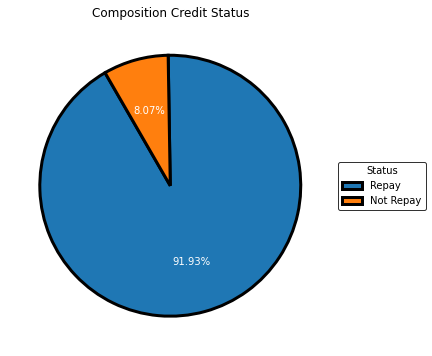

In [11]:
y_value_counts = train_data['TARGET'].value_counts()  #visualize composition of credit

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Will Repay","Will not Repay"]

data = [y_value_counts[0], y_value_counts[1]]

pie_1 = ax.pie(data,explode = (0,0),
        textprops=dict(size= 10, color= "white"),
        autopct="%.2f%%",startangle = 120,wedgeprops=dict( edgecolor = "black", linewidth = 3))

labels="Repay","Not Repay"

plt.title('Composition Credit Status')
plt.legend( labels, title="Status",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1), edgecolor = "black")

Distribution train dataset

In [12]:
def stack_plot(data, xtick, col2='TARGET', col3='total'):  #define for ditribution data
 ind = np.arange(data.shape[0])

 if len(data[xtick].unique())<5:
    plt.figure(figsize=(5,5))
 elif len(data[xtick].unique())>=5 & len(data[xtick].unique())<10:
    plt.figure(figsize=(7,7))
 else:
    plt.figure(figsize=(10,10))
    
 p1 = plt.bar(ind, data[col3].values)
 p2 = plt.bar(ind, data[col2].values)
 
 plt.ylabel('Loans')

 plt.xticks(ticks=ind, rotation=90,labels= list(data[xtick].values))
 plt.legend((p1[0], p2[0]), ('capable', 'not capable'))
 
 plt.show()

def barplots(data, col1, col2='TARGET', top=False):
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']


    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp)

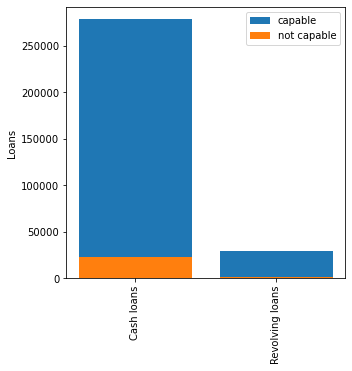

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [13]:

barplots(train_data, 'NAME_CONTRACT_TYPE', 'TARGET')


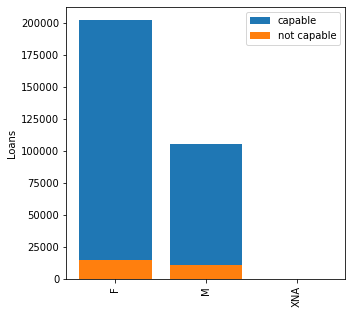

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [14]:
barplots(train_data, 'CODE_GENDER', 'TARGET')


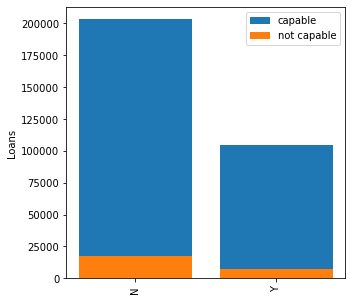

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [15]:
barplots(train_data, 'FLAG_OWN_CAR', 'TARGET')

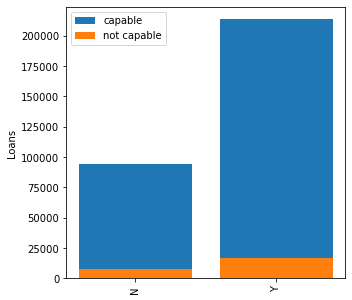

  FLAG_OWN_REALTY  TARGET   total       Avg
0               N    7842   94199  0.083249
1               Y   16983  213312  0.079616


In [16]:
barplots(train_data, 'FLAG_OWN_REALTY', 'TARGET')

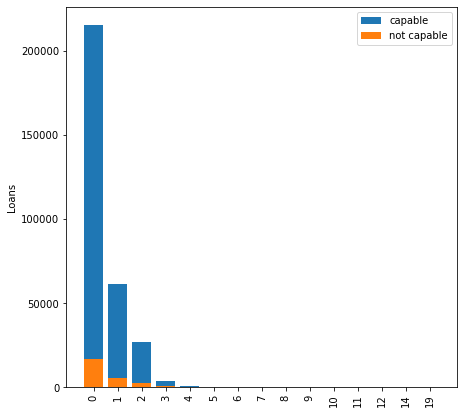

    CNT_CHILDREN  TARGET   total       Avg
0              0   16609  215371  0.077118
1              1    5454   61119  0.089236
2              2    2333   26749  0.087218
3              3     358    3717  0.096314
4              4      55     429  0.128205
5              5       7      84  0.083333
6              6       6      21  0.285714
7              7       0       7  0.000000
8              8       0       2  0.000000
9              9       2       2  1.000000
10            10       0       2  0.000000
11            11       1       1  1.000000
12            12       0       2  0.000000
13            14       0       3  0.000000
14            19       0       2  0.000000


In [17]:
barplots(train_data, 'CNT_CHILDREN', 'TARGET')

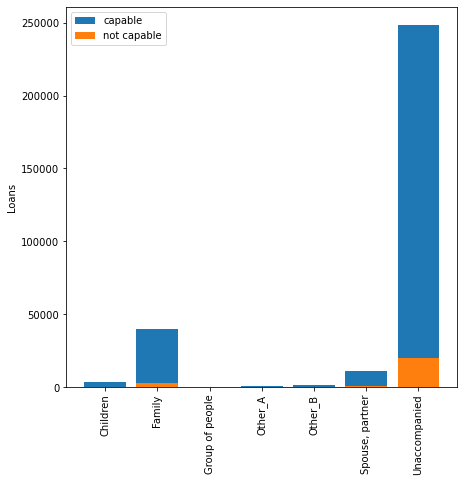

   NAME_TYPE_SUITE  TARGET   total       Avg
0         Children     241    3267  0.073768
1           Family    3009   40149  0.074946
2  Group of people      23     271  0.084871
3          Other_A      76     866  0.087760
4          Other_B     174    1770  0.098305
5  Spouse, partner     895   11370  0.078716
6    Unaccompanied   20337  248526  0.081830


In [18]:
barplots(train_data, 'NAME_TYPE_SUITE', 'TARGET')

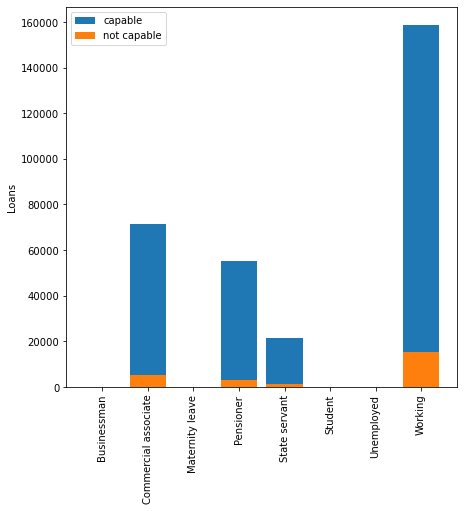

       NAME_INCOME_TYPE  TARGET   total       Avg
0           Businessman       0      10  0.000000
1  Commercial associate    5360   71617  0.074843
2       Maternity leave       2       5  0.400000
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
5               Student       0      18  0.000000
6            Unemployed       8      22  0.363636
7               Working   15224  158774  0.095885


In [19]:
barplots(train_data, 'NAME_INCOME_TYPE', 'TARGET')

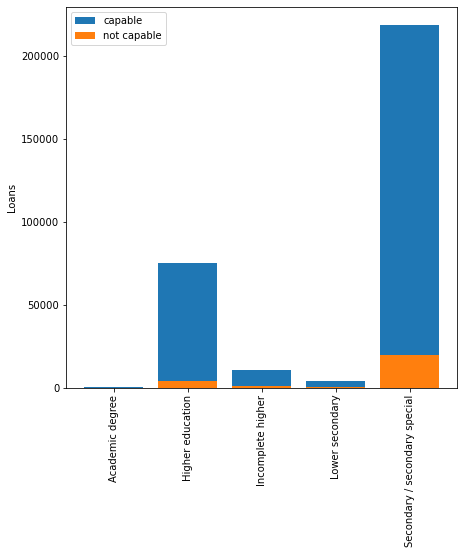

             NAME_EDUCATION_TYPE  TARGET   total       Avg
0                Academic degree       3     164  0.018293
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
4  Secondary / secondary special   19524  218391  0.089399


In [20]:
barplots(train_data, 'NAME_EDUCATION_TYPE', 'TARGET')


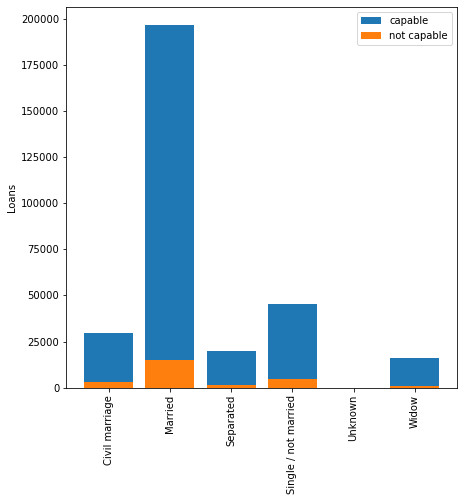

     NAME_FAMILY_STATUS  TARGET   total       Avg
0        Civil marriage    2961   29775  0.099446
1               Married   14850  196432  0.075599
2             Separated    1620   19770  0.081942
3  Single / not married    4457   45444  0.098077
4               Unknown       0       2  0.000000
5                 Widow     937   16088  0.058242


In [21]:
barplots(train_data, 'NAME_FAMILY_STATUS', 'TARGET')

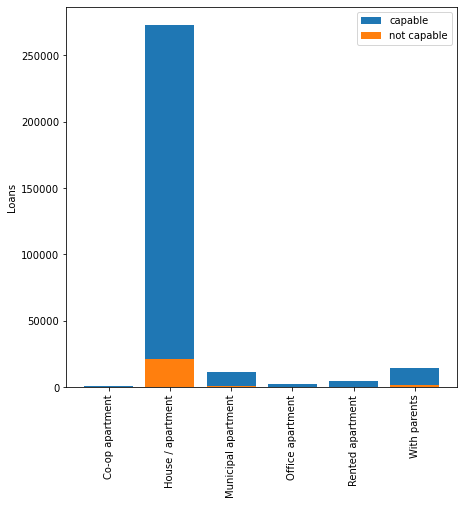

     NAME_HOUSING_TYPE  TARGET   total       Avg
0      Co-op apartment      89    1122  0.079323
1    House / apartment   21272  272868  0.077957
2  Municipal apartment     955   11183  0.085397
3     Office apartment     172    2617  0.065724
4     Rented apartment     601    4881  0.123131
5         With parents    1736   14840  0.116981


In [22]:
barplots(train_data, 'NAME_HOUSING_TYPE', 'TARGET')

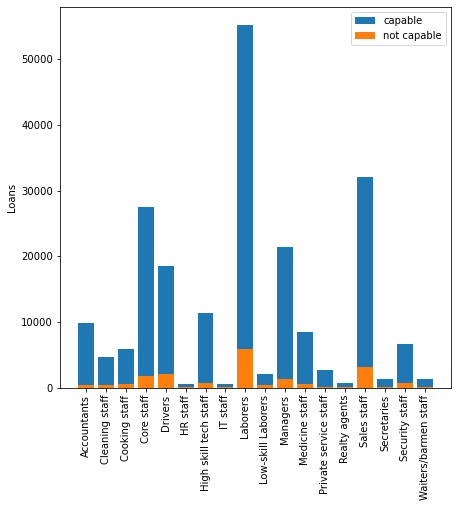

          OCCUPATION_TYPE  TARGET  total       Avg
0             Accountants     474   9813  0.048303
1          Cleaning staff     447   4653  0.096067
2           Cooking staff     621   5946  0.104440
3              Core staff    1738  27570  0.063040
4                 Drivers    2107  18603  0.113261
5                HR staff      36    563  0.063943
6   High skill tech staff     701  11380  0.061599
7                IT staff      34    526  0.064639
8                Laborers    5838  55186  0.105788
9      Low-skill Laborers     359   2093  0.171524
10               Managers    1328  21371  0.062140
11         Medicine staff     572   8537  0.067002
12  Private service staff     175   2652  0.065988
13          Realty agents      59    751  0.078562
14            Sales staff    3092  32102  0.096318
15            Secretaries      92   1305  0.070498
16         Security staff     722   6721  0.107424
17   Waiters/barmen staff     152   1348  0.112760


In [23]:
barplots(train_data, 'OCCUPATION_TYPE', 'TARGET', False)

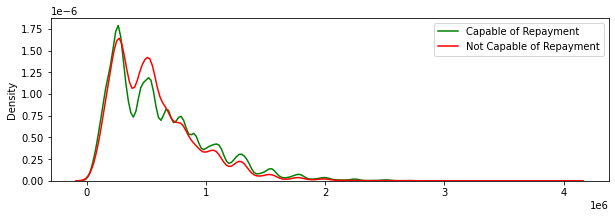

In [24]:
approved_loan_credit = train_data[train_data['TARGET']==0]['AMT_CREDIT'].values
rejected_loan_credit = train_data[train_data['TARGET']==1]['AMT_CREDIT'].values

plt.figure(figsize=(10,3))
sns.distplot(approved_loan_credit,hist=False,label="Capable of Repayment", color='green')
sns.distplot(rejected_loan_credit,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()


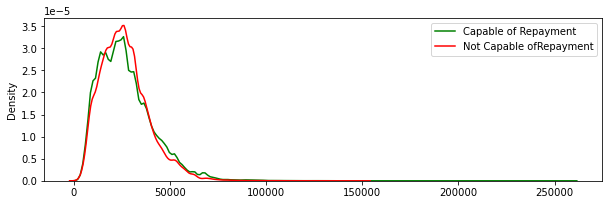

In [25]:
capable_loan_annuity = train_data[train_data['TARGET']==0]['AMT_ANNUITY'].values
not_capable_loan_annuity = train_data[train_data['TARGET']==1]['AMT_ANNUITY'].values


plt.figure(figsize=(10,3))
sns.distplot(capable_loan_annuity,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_annuity,hist=False,label="Not Capable ofRepayment", color='red')
plt.legend()
plt.show()


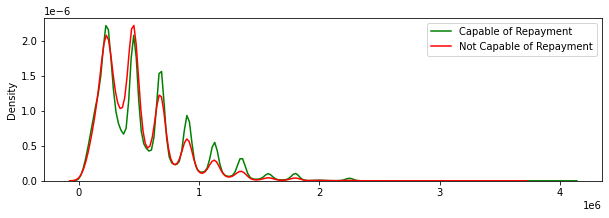

In [26]:
capable_loan_goods_price = train_data[train_data['TARGET']==0]['AMT_GOODS_PRICE'].values
not_capable_loan_goods_price = train_data[train_data['TARGET']==1]['AMT_GOODS_PRICE'].values  

plt.figure(figsize=(10,3))
sns.distplot(capable_loan_goods_price,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_goods_price,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()


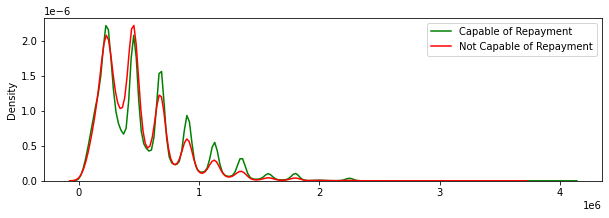

In [27]:
capable_loan_income_total = train_data[train_data['TARGET']==0]['AMT_INCOME_TOTAL'].values
not_capable_loan_income_total = train_data[train_data['TARGET']==1]['AMT_INCOME_TOTAL'].values  

plt.figure(figsize=(10,3))
sns.distplot(capable_loan_goods_price,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_loan_goods_price,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

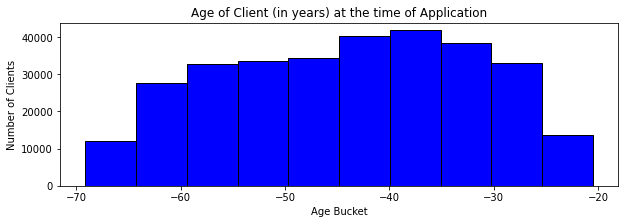

In [28]:
plt.figure(figsize=(10,3))
plt.hist(train_data['DAYS_BIRTH'].values/365, bins=10, edgecolor='black', color='blue')
plt.title('Age of Client (in years) at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()


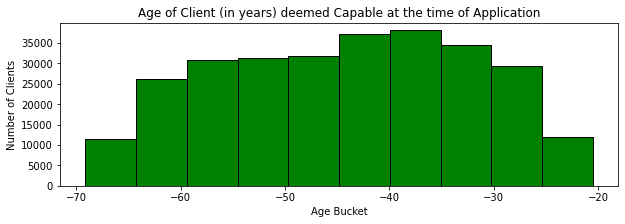

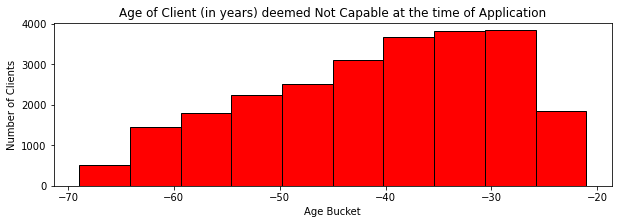

In [29]:
capable_days_birth = train_data[train_data['TARGET']==0]['DAYS_BIRTH'].values/365
not_capable_days_birth = train_data[train_data['TARGET']==1]['DAYS_BIRTH'].values/365


plt.figure(figsize=(10,3))
plt.hist(capable_days_birth, bins=10, edgecolor='black', color='green')
plt.title('Age of Client (in years) deemed Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(not_capable_days_birth, bins=10, edgecolor='black', color='red')
plt.title('Age of Client (in years) deemed Not Capable at the time of Application')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

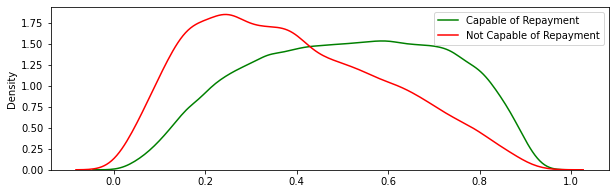

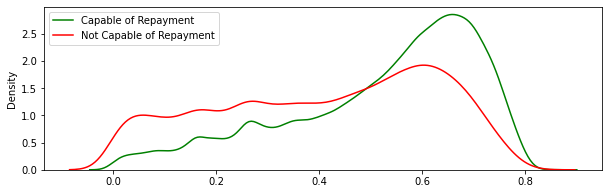

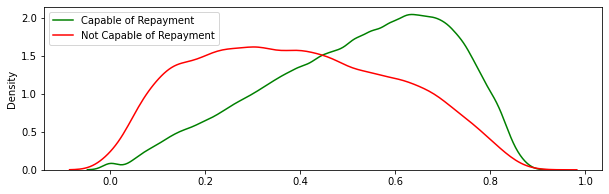

In [30]:
capable_ext_source_1 = train_data[train_data['TARGET']==0]['EXT_SOURCE_1'].values
not_capable_ext_source_1 = train_data[train_data['TARGET']==1]['EXT_SOURCE_1'].values

plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_1,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_1,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

capable_ext_source_2 = train_data[train_data['TARGET']==0]['EXT_SOURCE_2'].values
not_capable_ext_source_2 = train_data[train_data['TARGET']==1]['EXT_SOURCE_2'].values

plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_2,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_2,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

capable_ext_source_3 = train_data[train_data['TARGET']==0]['EXT_SOURCE_3'].values
not_capable_ext_source_3 = train_data[train_data['TARGET']==1]['EXT_SOURCE_3'].values

plt.figure(figsize=(10,3))
sns.distplot(capable_ext_source_3,hist=False,label="Capable of Repayment", color='green')
sns.distplot(not_capable_ext_source_3,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

# Data preparation

In [31]:
print('Number of duplicates train data : ',train_data.duplicated().sum()) # checking duplicated data
print('Number of duplicates test data : ',train_data.duplicated().sum())

Number of duplicates train data :  0
Number of duplicates test data :  0


In [32]:
#handling missing data
train_data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
train_data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)
train_data.replace(max(train_data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

train_data['AMT_ANNUITY'].fillna(0, inplace=True)
#A total of 36 datapoints are there where Annuity Amount is null.

train_data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
#A total of 278 datapoints are there where Annuity Amount is null.

train_data['NAME_TYPE_SUITE'].fillna('Data_Not_Available', inplace=True)
#Removing datapoints where 'Name_Type_Suite' is null.

train_data['NAME_FAMILY_STATUS'].replace('Unknown','Married', inplace=True)
#Removing datapoints where 'Name_Family_Status' is Unknown.

train_data['OCCUPATION_TYPE'].fillna(train_data['OCCUPATION_TYPE'].mode(), inplace=True)
train_data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
train_data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
train_data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
train_data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

train_data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

#Replace NA with the most frequently occuring class for Count of Client Family Members
train_data['CNT_FAM_MEMBERS'].fillna(train_data['CNT_FAM_MEMBERS'].value_counts().idxmax(), \
                                             inplace=True)

train_data['EXT_SOURCE_1'].fillna(0, inplace=True)
train_data['EXT_SOURCE_2'].fillna(0, inplace=True)
train_data['EXT_SOURCE_3'].fillna(0, inplace=True)
train_data['SK_ID_CURR'].fillna(0,inplace=True)

In [33]:
missing_data = train_data.isnull().sum(axis=0).reset_index()  #checking missing value for train data
missing_data.columns=['variable','missing values']
missing_data['filling factor %']=(train_data.shape[0]-missing_data['missing values'])/train_data.shape[0]*100
missing_data.reset_index(drop = True)

pd.set_option('display.max_rows', None)
missing_data.sort_values(by='missing values',ascending = False).head(65)

,variable,missing values,filling factor %
76,COMMONAREA_MEDI,214865,30.127703
48,COMMONAREA_AVG,214865,30.127703
62,COMMONAREA_MODE,214865,30.127703
70,NONLIVINGAPARTMENTS_MODE,213514,30.567037
56,NONLIVINGAPARTMENTS_AVG,213514,30.567037
84,NONLIVINGAPARTMENTS_MEDI,213514,30.567037
86,FONDKAPREMONT_MODE,210295,31.613828
68,LIVINGAPARTMENTS_MODE,210199,31.645047
82,LIVINGAPARTMENTS_MEDI,210199,31.645047
54,LIVINGAPARTMENTS_AVG,210199,31.645047


# Other dataset

In [34]:
bureau_data.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [35]:
missing_data = bureau_data.isnull().sum(axis=0).reset_index()  #checking missing value for train data
missing_data.columns=['variable','missing values']
missing_data['filling factor %']=(bureau_data.shape[0]-missing_data['missing values'])/bureau_data.shape[0]*100
missing_data.sort_values('filling factor %').reset_index(drop = True)

pd.set_option('display.max_rows', None)
missing_data.sort_values(by='missing values',ascending = False).head(65)

,variable,missing values,filling factor %
16,AMT_ANNUITY,1226791,28.526510
8,AMT_CREDIT_MAX_OVERDUE,1124488,34.486736
7,DAYS_ENDDATE_FACT,633653,63.083042
12,AMT_CREDIT_SUM_LIMIT,591780,65.522585
11,AMT_CREDIT_SUM_DEBT,257669,84.988068
6,DAYS_CREDIT_ENDDATE,105553,93.850427
10,AMT_CREDIT_SUM,13,99.999243
2,CREDIT_ACTIVE,0,100.000000
3,CREDIT_CURRENCY,0,100.000000
4,DAYS_CREDIT,0,100.000000


In [36]:
bureau_data['AMT_ANNUITY'].fillna(0,inplace=True)
bureau_data['AMT_CREDIT_SUM'].fillna(0,inplace=True)
bureau_data['DAYS_CREDIT_ENDDATE'].fillna(0,inplace=True)
bureau_data['AMT_CREDIT_SUM_DEBT'].fillna(0,inplace=True)


In [37]:
bureau_data=reduce_mem_usage(bureau_data.drop(bureau_data.columns[bureau_data.isnull().sum()>0],axis=1))

Memory usage after optimization is: 96.58 MB
Decreased by 0.0%


In [38]:
catcol = [col for col in bureau_data.columns if bureau_data[col].dtype == "object"] #encoding data
le = LabelEncoder()
for col in catcol:
        bureau_data[col] = le.fit_transform(bureau_data[col])

In [39]:
previous_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
missing_data = previous_app.isnull().sum(axis=0).reset_index()  #checking missing value for train data
missing_data.columns=['variable','missing values']
missing_data['filling factor %']=(previous_app.shape[0]-missing_data['missing values'])/previous_app.shape[0]*100
missing_data.sort_values('filling factor %').reset_index(drop = True)

pd.set_option('display.max_rows', None)
missing_data.sort_values(by='missing values',ascending = False).head(65)

,variable,missing values,filling factor %
14,RATE_INTEREST_PRIVILEGED,1664263,0.356302
13,RATE_INTEREST_PRIMARY,1664263,0.356302
6,AMT_DOWN_PAYMENT,895844,46.363520
12,RATE_DOWN_PAYMENT,895844,46.363520
20,NAME_TYPE_SUITE,820405,50.880246
36,NFLAG_INSURED_ON_APPROVAL,673065,59.701871
35,DAYS_TERMINATION,673065,59.701871
34,DAYS_LAST_DUE,673065,59.701871
33,DAYS_LAST_DUE_1ST_VERSION,673065,59.701871
32,DAYS_FIRST_DUE,673065,59.701871


In [41]:
previous_app.AMT_CREDIT.fillna(0,inplace=True)
previous_app.AMT_ANNUITY.fillna(0,inplace=True)
previous_app.AMT_GOODS_PRICE.fillna(0,inplace=True)
previous_app.PRODUCT_COMBINATION.fillna('Data Unavailable',inplace=True)
previous_app.CNT_PAYMENT.fillna(0,inplace=True)

In [42]:
previous_app=reduce_mem_usage(previous_app.drop(previous_app.columns[previous_app.isnull().sum()>0],axis=1))

Memory usage after optimization is: 245.30 MB
Decreased by 0.0%


In [43]:
catcol = [col for col in previous_app.columns if previous_app[col].dtype == "object"] #encoding data
le = LabelEncoder()
for col in catcol:
        previous_app[col] = le.fit_transform(previous_app[col])

In [44]:
df=train_data #define the new dataset

In [45]:
missing_data = df.isnull().sum(axis=0).reset_index()  #checking missing value for train data
missing_data.columns=['variable','missing values']
missing_data['filling factor %']=(df.shape[0]-missing_data['missing values'])/df.shape[0]*100
missing_data.sort_values('filling factor %').reset_index(drop = True)

pd.set_option('display.max_rows', None)
missing_data.sort_values(by='missing values',ascending = False).head(65)

,variable,missing values,filling factor %
76,COMMONAREA_MEDI,214865,30.127703
48,COMMONAREA_AVG,214865,30.127703
62,COMMONAREA_MODE,214865,30.127703
70,NONLIVINGAPARTMENTS_MODE,213514,30.567037
56,NONLIVINGAPARTMENTS_AVG,213514,30.567037
84,NONLIVINGAPARTMENTS_MEDI,213514,30.567037
86,FONDKAPREMONT_MODE,210295,31.613828
68,LIVINGAPARTMENTS_MODE,210199,31.645047
82,LIVINGAPARTMENTS_MEDI,210199,31.645047
54,LIVINGAPARTMENTS_AVG,210199,31.645047


In [46]:
df['DAYS_EMPLOYED'].fillna(0,inplace=True)
df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0,inplace=True)
df.AMT_REQ_CREDIT_BUREAU_WEEK.fillna(0,inplace=True)
df.AMT_REQ_CREDIT_BUREAU_MON.fillna(0,inplace=True)
df.AMT_REQ_CREDIT_BUREAU_HOUR.fillna(0,inplace=True)
df.AMT_REQ_CREDIT_BUREAU_QRT.fillna(0,inplace=True)
df.AMT_REQ_CREDIT_BUREAU_YEAR.fillna(0,inplace=True)
df.SK_ID_CURR.fillna(0,inplace=True)


In [47]:
df=reduce_mem_usage(df.drop(df.columns[df.isnull().sum()>0],axis=1))

Memory usage after optimization is: 53.67 MB
Decreased by 5.2%


In [48]:
#df=pd.get_dummies(df,columns=['TARGET'])

In [49]:
#df.to_csv(r'C:\Users\Boydo\Downloads\df1.csv')

In [50]:
catcol = [col for col in df.columns if df[col].dtype == "object"] #encoding data
le = LabelEncoder()
for col in catcol:
        df[col] = le.fit_transform(df[col])

Join Data

In [51]:
df_merge=reduce_mem_usage(df.merge(bureau_data,how='left').merge(previous_app,how='left')) #left join the data

Memory usage after optimization is: 52.50 MB
Decreased by 50.7%


In [52]:
missing_data = df_merge.isnull().sum(axis=0).reset_index()  #checking missing value for train data
missing_data.columns=['variable','missing values']
missing_data['filling factor %']=(df_merge.shape[0]-missing_data['missing values'])/df_merge.shape[0]*100
missing_data.sort_values('filling factor %').reset_index(drop = True)

pd.set_option('display.max_rows', None)
missing_data.sort_values(by='missing values',ascending = False).head(65)

,variable,missing values,filling factor %
99,PRODUCT_COMBINATION,307523,0.000976
90,NAME_CLIENT_TYPE,307523,0.000976
81,SK_ID_PREV,307523,0.000976
82,AMT_APPLICATION,307523,0.000976
83,FLAG_LAST_APPL_PER_CONTRACT,307523,0.000976
84,NFLAG_LAST_APPL_IN_DAY,307523,0.000976
85,NAME_CASH_LOAN_PURPOSE,307523,0.000976
86,NAME_CONTRACT_STATUS,307523,0.000976
87,DAYS_DECISION,307523,0.000976
89,CODE_REJECT_REASON,307523,0.000976


In [53]:
df_merge=reduce_mem_usage(df_merge.drop(df_merge.columns[df_merge.isnull().sum()>0],axis=1)) #handling data

Memory usage after optimization is: 31.38 MB
Decreased by 0.0%


In [54]:
df_merge=df_merge.drop_duplicates()#handling data

In [55]:
#handling data
df_merge=df_merge.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','SK_ID_CURR'],axis=1)

# Correlation

In [56]:
df_correlation=df_merge.corr(method='pearson').TARGET.sort_index().reset_index()

In [57]:
print('Most positive correlation')
df_correlationhead=df_correlation.sort_values(by='TARGET',ascending=False).iloc[1:11]
df_correlationhead

Most positive correlation


,index,TARGET
13,DAYS_BIRTH,0.078239
41,REGION_RATING_CLIENT_W_CITY,0.060893
40,REGION_RATING_CLIENT,0.058899
32,NAME_EDUCATION_TYPE,0.054699
12,CODE_GENDER,0.054692
15,DAYS_ID_PUBLISH,0.051457
43,REG_CITY_NOT_WORK_CITY,0.050994
35,NAME_INCOME_TYPE,0.046829
14,DAYS_EMPLOYED,0.046052
22,FLAG_EMP_PHONE,0.045982


In [58]:
corrmap=df_merge[['DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','NAME_EDUCATION_TYPE','REGION_RATING_CLIENT','DAYS_ID_PUBLISH',
'CODE_GENDER','NAME_INCOME_TYPE','FLAG_EMP_PHONE','NAME_HOUSING_TYPE','DAYS_REGISTRATION']]

In [59]:
print('Most negative correlation')
df_correlationtail=df_correlation.sort_values(by='TARGET',ascending=False).tail(10)
df_correlationtail

Most negative correlation


,index,TARGET
26,FLAG_PHONE,-0.023806
28,HOUR_APPR_PROCESS_START,-0.024166
1,AMT_CREDIT,-0.030369
38,ORGANIZATION_TYPE,-0.030765
31,NAME_CONTRACT_TYPE,-0.030896
39,REGION_POPULATION_RELATIVE,-0.037231
2,AMT_GOODS_PRICE,-0.039565
17,EXT_SOURCE_1,-0.064698
19,EXT_SOURCE_3,-0.119572
18,EXT_SOURCE_2,-0.159029


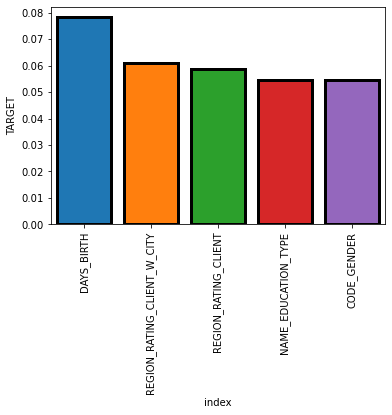

In [60]:
chart = sns.barplot(data=df_correlationhead.head(),x="index",y="TARGET",saturation=1, edgecolor = "#000000", linewidth = 3)

for item in chart.get_xticklabels():
  item.set_rotation(90)

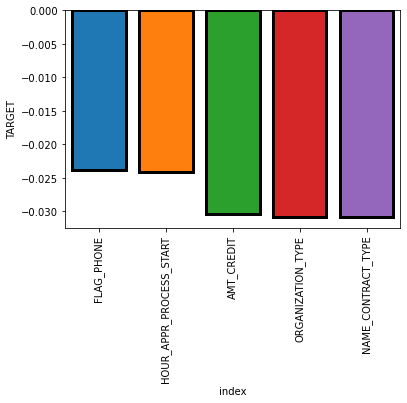

In [61]:
chart = sns.barplot(data=df_correlationtail.head(),x="index",y="TARGET",saturation=1, edgecolor = "#000000", linewidth = 3)

for item in chart.get_xticklabels():
  item.set_rotation(90)

Text(0.5, 1.0, '\nHeatmap for top 10 most positive correlation\n')

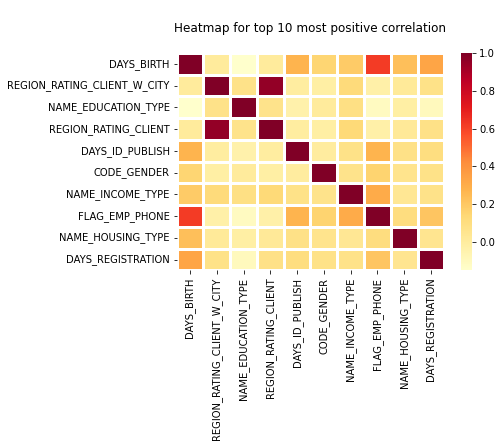

In [62]:
sns.heatmap(corrmap.corr(),cmap="YlOrRd", edgecolor = "#1c1c1c", linewidth = 3)
plt.title(f'\nHeatmap for top 10 most positive correlation\n')

# Machine Learning

In [63]:
X=df_merge.drop(['TARGET'],1)
y=df_merge[['TARGET']]



In [64]:
import imblearn

from imblearn.over_sampling import RandomOverSampler

oversample=RandomOverSampler(sampling_strategy=0.5)
X_over,y_over=oversample.fit_resample(X,y)

In [65]:
train_X,test_X,train_y,test_y = train_test_split(X_over,y_over,test_size=0.2,random_state=0)

XGBboost Classifier

In [66]:
xgboost=XGBClassifier()
xgboost.fit(train_X,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

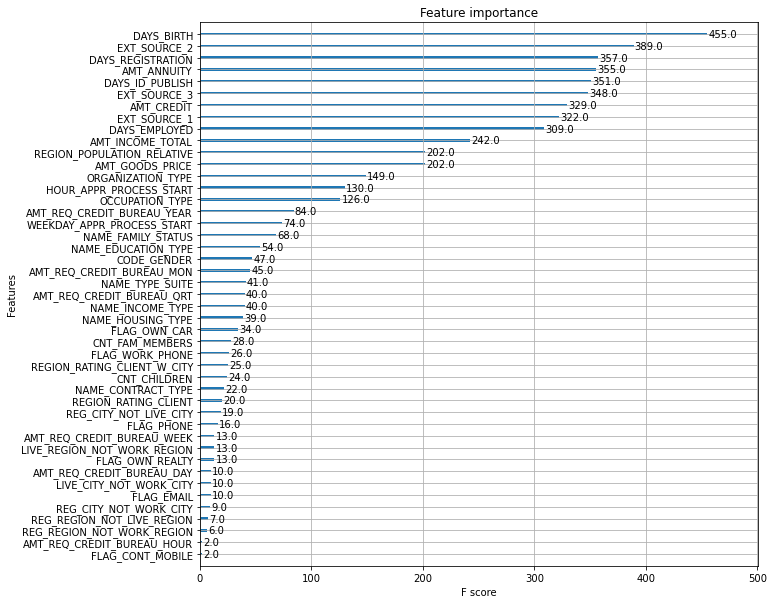

In [67]:
fig=plt.figure(figsize=(10,10))
xgb.plot_importance(xgboost, ax=plt.gca())

plt.show()

In [68]:
xgboost_pred=xgboost.predict(test_X)
xgboost_conf=confusion_matrix(test_y,xgboost_pred)
xgboost_report=classification_report(test_y,xgboost_pred)
xgboost_acc=round(accuracy_score(test_y,xgboost_pred)*100,ndigits=3)
xgboost_rocauc=roc_auc_score(test_y, xgboost_pred)
print(f"Confusion Matrix : \n\n{xgboost_conf}")
print(f"\nClassification Report : \n\n{xgboost_report}")
print(f"\nThe Accuracy of XGB is {xgboost_acc} %")
print(f'ROC AUC Score with XGBOOST: {xgboost_rocauc}')


Confusion Matrix : 

[[50349  6150]
 [13896 14411]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.78      0.89      0.83     56499
           1       0.70      0.51      0.59     28307

    accuracy                           0.76     84806
   macro avg       0.74      0.70      0.71     84806
weighted avg       0.76      0.76      0.75     84806


The Accuracy of XGB is 76.363 %
ROC AUC Score with XGBOOST: 0.7001226028838171


In [69]:
z=xgboost_conf
fig1 = ff.create_annotated_heatmap(z, x=['Not Capable Repay','Capable Repay'], y=['Predicted Not Capable Repay','Predicted Capable Repay'], colorscale='YlOrRd',xgap=3,ygap=3)
fig1['data'][0]['showscale'] = True

fig1.update_layout(title_text='<b>Confusion Matrix for XGBoost<b>',
                  title_x=0.5,
                  titlefont={'size': 20},
                  width=600, height=400,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed'
                  )

Decision Tree Classifier

In [70]:
dtr=DecisionTreeClassifier()

dtr.fit(train_X,train_y)


DecisionTreeClassifier()

<AxesSubplot:>

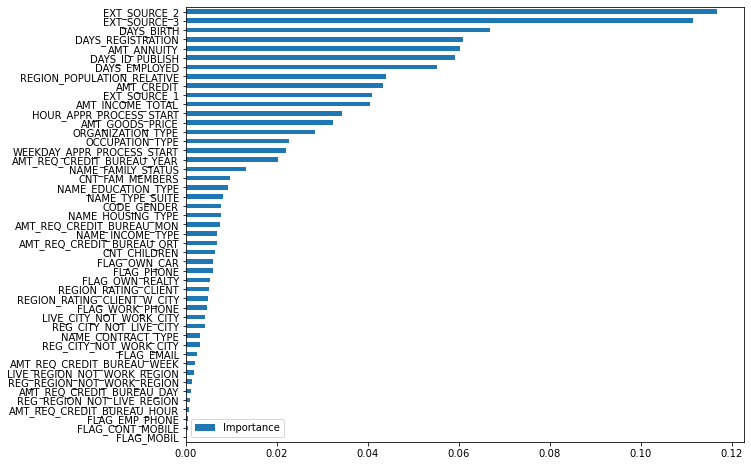

In [71]:
feat_importances = pd.DataFrame(dtr.feature_importances_, index=test_X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot(kind='barh',figsize=(10,8))


In [72]:
dtr_pred=dtr.predict(test_X)
dtr_conf=confusion_matrix(test_y,dtr_pred)
dtr_report=classification_report(test_y,dtr_pred)
dtr_acc=round(accuracy_score(test_y,dtr_pred)*100,ndigits=3)
dtr_rocauc=roc_auc_score(test_y, dtr_pred)
print(f"Confusion Matrix : \n\n{dtr_conf}")
print(f"\nClassification Report : \n\n{dtr_report}")
print(f"\nThe Accuracy of Decision Tree is {dtr_acc} %")
print(f'ROC AUC Score with Decision Tree: {dtr_rocauc}')

Confusion Matrix : 

[[51002  5497]
 [  174 28133]]

Classification Report : 

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56499
           1       0.84      0.99      0.91     28307

    accuracy                           0.93     84806
   macro avg       0.92      0.95      0.93     84806
weighted avg       0.94      0.93      0.93     84806


The Accuracy of Decision Tree is 93.313 %
ROC AUC Score with Decision Tree: 0.9482796765631969


Gaussian naive bayes classifier

In [73]:
gnb=GaussianNB()

gnb.fit(train_X,train_y)


GaussianNB()

In [74]:
gnb_pred=gnb.predict(test_X)
gnb_conf=confusion_matrix(test_y,gnb_pred)
gnb_report=classification_report(test_y,gnb_pred)
gnb_acc=round(accuracy_score(test_y,gnb_pred)*100,ndigits=3)
gnb_rocauc=roc_auc_score(test_y, gnb_pred)
print(f"Confusion Matrix : \n\n{gnb_conf}")
print(f"\nClassification Report : \n\n{gnb_report}")
print(f"\nThe Accuracy of Gaussian is {gnb_acc} %")
print(f'ROC AUC Score with Gaussian Naive Bayes: {gnb_rocauc}',)

Confusion Matrix : 

[[55730   769]
 [27923   384]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.67      0.99      0.80     56499
           1       0.33      0.01      0.03     28307

    accuracy                           0.66     84806
   macro avg       0.50      0.50      0.41     84806
weighted avg       0.56      0.66      0.54     84806


The Accuracy of Gaussian is 66.167 %
ROC AUC Score with Gaussian Naive Bayes: 0.49997734439412106


SGD Classifier

In [75]:
sgd=SGDClassifier()

sgd.fit(train_X,train_y)

SGDClassifier()

In [76]:
sgd_pred=sgd.predict(test_X)
sgd_conf=confusion_matrix(test_y,sgd_pred)
sgd_report=classification_report(test_y,sgd_pred)
sgd_acc=round(accuracy_score(test_y,gnb_pred)*100,ndigits=3)
sgd_rocauc=roc_auc_score(test_y, sgd_pred)
print(f"Confusion Matrix : \n\n{sgd_conf}")
print(f"\nClassification Report : \n\n{sgd_report}")
print(f"\nThe Accuracy of SGD is {sgd_acc} %")
print(f'ROC AUC Score with SGD: {sgd_rocauc}')

Confusion Matrix : 

[[23195 33304]
 [ 9592 18715]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.71      0.41      0.52     56499
           1       0.36      0.66      0.47     28307

    accuracy                           0.49     84806
   macro avg       0.53      0.54      0.49     84806
weighted avg       0.59      0.49      0.50     84806


The Accuracy of SGD is 66.167 %
ROC AUC Score with SGD: 0.535841063143001


Gradien Boost Classifier

In [77]:
gradien=GradientBoostingClassifier()

gradien.fit(train_X,train_y)

GradientBoostingClassifier()

In [78]:
gradien_pred=gradien.predict(test_X)
gradien_conf=confusion_matrix(test_y,gradien_pred)
gradien_report=classification_report(test_y,gradien_pred)
gradien_acc=round(accuracy_score(test_y,gradien_pred)*100,ndigits=3)
gradien_rocauc=roc_auc_score(test_y, gradien_pred)
print(f"Confusion Matrix : \n\n{gradien_conf}")
print(f"\nClassification Report : \n\n{gradien_report}")
print(f"\nThe Accuracy of Gradien Boost is {gradien_acc} %")
print(f'ROC AUC score wiht Gradien Boost: {gradien_rocauc}')

Confusion Matrix : 

[[50730  5769]
 [17286 11021]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.75      0.90      0.81     56499
           1       0.66      0.39      0.49     28307

    accuracy                           0.73     84806
   macro avg       0.70      0.64      0.65     84806
weighted avg       0.72      0.73      0.71     84806


The Accuracy of Gradien Boost is 72.814 %
ROC AUC score wiht Gradien Boost: 0.6436151621487632


Random Forest Classifier

In [79]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42) 
rfc.fit(train_X,train_y)


RandomForestClassifier(random_state=42)

In [80]:
rfc_pred = rfc.predict(test_X)
rfc_conf = confusion_matrix(test_y, rfc_pred)
rfc_report = classification_report(test_y, rfc_pred)
rfc_acc = round(accuracy_score(test_y, rfc_pred)*100, ndigits = 2)
rfc_rocauc=roc_auc_score(test_y, rfc_pred)
print(f"Confusion Matrix : \n\n{rfc_conf}")
print(f"\nClassification Report : \n\n{rfc_report}")
print(f"\nThe Accuracy of Random Forest Classifier is {rfc_acc} %")
print(f'ROC AUC score wiht Random Forest: {rfc_rocauc}')

Confusion Matrix : 

[[56323   176]
 [  197 28110]]

Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56499
           1       0.99      0.99      0.99     28307

    accuracy                           1.00     84806
   macro avg       1.00      0.99      1.00     84806
weighted avg       1.00      1.00      1.00     84806


The Accuracy of Random Forest Classifier is 99.56 %
ROC AUC score wiht Random Forest: 0.9949627456421648


Logistic Regression

In [81]:
lr=LogisticRegression()
lr.fit(train_X,train_y)

LogisticRegression()

In [82]:
lr_pred = lr.predict(test_X)
lr_conf = confusion_matrix(test_y, lr_pred)
lr_report = classification_report(test_y, lr_pred)
lr_acc = round(accuracy_score(test_y, lr_pred)*100, ndigits = 2)
lr_rocauc=roc_auc_score(test_y, lr_pred)
print(f"Confusion Matrix : \n\n{lr_conf}")
print(f"\nClassification Report : \n\n{lr_report}")
print(f"\nThe Accuracy of Logistic Reggresion is {lr_acc} %")
print(f'ROC AUC score wiht Logistic Reggresion: {lr_rocauc}')

Confusion Matrix : 

[[56008   491]
 [27690   617]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.67      0.99      0.80     56499
           1       0.56      0.02      0.04     28307

    accuracy                           0.67     84806
   macro avg       0.61      0.51      0.42     84806
weighted avg       0.63      0.67      0.55     84806


The Accuracy of Logistic Reggresion is 66.77 %
ROC AUC score wiht Logistic Reggresion: 0.5065531547124437


In [83]:
results = pd.DataFrame([["XGBoost Classifier", xgboost_acc, xgboost_rocauc],
                        ["Decision Tree Classifier", dtr_acc, dtr_rocauc], 
                        ["Gaussian naive bayes classifier", gnb_acc, gnb_rocauc],
                        ["Gradien Boost Classifier", gradien_acc, gradien_rocauc],
                        ["Random Forest Classifier", rfc_acc, rfc_rocauc],
                        ["Logistic Regression",lr_acc,lr_rocauc],
                        ],
                        columns = ["Models", "Testing Accuracy Score", "ROC AUC Score"])

results.sort_values(by=['Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='YlOrRd')

,Models,Testing Accuracy Score,ROC AUC Score
4,Random Forest Classifier,99.560000,0.994963
1,Decision Tree Classifier,93.313000,0.948280
0,XGBoost Classifier,76.363000,0.700123
3,Gradien Boost Classifier,72.814000,0.643615
5,Logistic Regression,66.770000,0.506553
2,Gaussian naive bayes classifier,66.167000,0.499977
